In [1]:
# SparkSession başlat (zaten başlattıysan tekrar gerek yok)
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ClimateNewsAnalysis").getOrCreate()

# GDELT ve iklim verilerini oku
gdelt_path = "/home/jovyan/work/data_storage/gdelt/*.csv"
climate_path = "/home/jovyan/work/data_storage/climate/*.csv"

gdelt_df = spark.read.option("header", True).csv(gdelt_path)
climate_df = spark.read.option("header", True).csv(climate_path)

# Sütun isimleri ve örnek satırlar
print("GDELT Sütunlar:", gdelt_df.columns)
gdelt_df.show(5, truncate=100)
print("İklim Sütunlar:", climate_df.columns)
climate_df.show(5, truncate=100)

# Satır sayısı
print("GDELT satır sayısı:", gdelt_df.count())
print("İklim satır sayısı:", climate_df.count())

GDELT Sütunlar: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57']
+----------+--------+------+----+---------+---------+--------+----+----+----+----+----+----+----+----+---+--------+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+-----------------+---+--------------------------------------+---+----+-------+--------+--------+---+--------------------------------------+---+----+-------+--------+--------+---+--------------------------------------+---+----+-------+--------+--------+--------+----------------------------------------------------------------------------------------------------+
|         0|       1|     2|   3|        4|        5|       6|   7|   8|   9|  10|  11|  12

In [2]:
# GDELT resmi sütun isimleri (GDELT 2.0 Event CSV için)
gdelt_columns = [
    "GLOBALEVENTID", "SQLDATE", "MonthYear", "Year", "FractionDate",
    "Actor1Code", "Actor1Name", "Actor1CountryCode", "Actor1KnownGroupCode", "Actor1EthnicCode",
    "Actor1Religion1Code", "Actor1Religion2Code", "Actor1Type1Code", "Actor1Type2Code", "Actor1Type3Code",
    "Actor2Code", "Actor2Name", "Actor2CountryCode", "Actor2KnownGroupCode", "Actor2EthnicCode",
    "Actor2Religion1Code", "Actor2Religion2Code", "Actor2Type1Code", "Actor2Type2Code", "Actor2Type3Code",
    "IsRootEvent", "EventCode", "EventBaseCode", "EventRootCode", "QuadClass", "GoldsteinScale",
    "NumMentions", "NumSources", "NumArticles", "AvgTone",
    "Actor1Geo_Type", "Actor1Geo_FullName", "Actor1Geo_CountryCode", "Actor1Geo_ADM1Code", "Actor1Geo_Lat", "Actor1Geo_Long", "Actor1Geo_FeatureID",
    "Actor2Geo_Type", "Actor2Geo_FullName", "Actor2Geo_CountryCode", "Actor2Geo_ADM1Code", "Actor2Geo_Lat", "Actor2Geo_Long", "Actor2Geo_FeatureID",
    "ActionGeo_Type", "ActionGeo_FullName", "ActionGeo_CountryCode", "ActionGeo_ADM1Code", "ActionGeo_Lat", "ActionGeo_Long", "ActionGeo_FeatureID",
    "DATEADDED", "SOURCEURL"
]

# Sütunları yeniden adlandır
gdelt_df = gdelt_df.toDF(*gdelt_columns)

# Kontrol için ilk 5 satırı tekrar göster
gdelt_df.show(5, truncate=100)

+-------------+--------+---------+----+------------+----------+----------+-----------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+----------+----------+-----------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+-----------+---------+-------------+-------------+---------+--------------+-----------+----------+-----------+-----------------+--------------+--------------------------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+--------------------------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+--------------------------------------+---------------------+------------------+-------------+--------------+-------------------+---------+----------------------------------------------

In [3]:
from pyspark.sql.functions import when, col

# 1. "NULL" stringlerini gerçek null'a çevir
for c in gdelt_df.columns:
    gdelt_df = gdelt_df.withColumn(c, when(col(c) == "NULL", None).otherwise(col(c)))

# 2. Yıl ve ülke kodu alanlarını integer ve string olarak ayarla
gdelt_df = gdelt_df.withColumn("Year", col("Year").cast("int"))
climate_df = climate_df.withColumn("year", col("year").cast("int"))

# 3. Eşleştirme için GDELT'te bir ana ülke kodu sütunu oluştur (ör: Actor1CountryCode)
gdelt_df = gdelt_df.withColumnRenamed("Actor1CountryCode", "country_code")

# 4. GDELT ve iklim verisini yıl ve ülke koduna göre birleştir
merged_df = gdelt_df.join(
    climate_df,
    (gdelt_df["country_code"] == climate_df["country_code"]) & (gdelt_df["Year"] == climate_df["year"]),
    how="inner"
)

# 5. Sonuçları kontrol et
print("Birleşik satır sayısı:", merged_df.count())
merged_df.show(5, truncate=100)

Birleşik satır sayısı: 172
+-------------+--------+---------+----+------------+----------+--------------+------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+----------+-------------------+-----------------+--------------------+----------------+-------------------+-------------------+---------------+---------------+---------------+-----------+---------+-------------+-------------+---------+--------------+-----------+----------+-----------+-----------------+--------------+---------------------------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+---------------------------------------+---------------------+------------------+-------------+--------------+-------------------+--------------+---------------------------------------+---------------------+------------------+-------------+--------------+-------------------+---------+--------

In [5]:
from pyspark.sql.functions import count, avg

# 1. İklim verisinin sütunlarını yeniden adlandır
climate_df_renamed = climate_df \
    .withColumnRenamed("country_code", "climate_country_code") \
    .withColumnRenamed("country_name", "climate_country_name") \
    .withColumnRenamed("year", "climate_year") \
    .withColumnRenamed("value", "climate_value")

# 2. GDELT ve iklim verisini tekrar birleştir
merged_df = gdelt_df.join(
    climate_df_renamed,
    (gdelt_df["country_code"] == climate_df_renamed["climate_country_code"]) & (gdelt_df["Year"] == climate_df_renamed["climate_year"]),
    how="inner"
)

# 3. Artık çakışma yok, özetleri alabilirsin
summary_df = merged_df.groupBy("country_code", "Year", "climate_country_name") \
    .agg(
        count("*").alias("news_count"),
        avg("AvgTone").alias("avg_tone"),
        avg("climate_value").alias("climate_value")
    ) \
    .orderBy("news_count", ascending=False)

summary_df.show(10, truncate=100)

# Yıllara göre toplam haber sayısı ve ortalama iklim değeri
yearly_df = merged_df.groupBy("Year") \
    .agg(
        count("*").alias("total_news"),
        avg("AvgTone").alias("avg_tone"),
        avg("climate_value").alias("avg_climate_value")
    ) \
    .orderBy("Year")

yearly_df.show(10)

+------------+----+--------------------+----------+-------------------+-----------------+
|country_code|Year|climate_country_name|news_count|           avg_tone|    climate_value|
+------------+----+--------------------+----------+-------------------+-----------------+
|         USA|2014|       United States|        39|-1.5270639824120957|  5107209.9609375|
|         USA|2013|       United States|        23|-1.5111525799816186| 5092100.09765625|
|         CHN|2014|               China|        11| 1.5089192678229983|1.0006669921875E7|
|         SWE|2014|              Sweden|         9| -2.148017351000989| 39080.0018310547|
|         SRB|2014|              Serbia|         8|  2.869699897913512| 38959.9990844727|
|         JPN|2014|               Japan|         6|  -1.10234408577612| 1217119.99511719|
|         ISR|2014|              Israel|         6|   -2.5395468093307| 64720.0012207031|
|         HUN|2014|             Hungary|         5|0.11152834139154999| 40630.0010681152|
|         

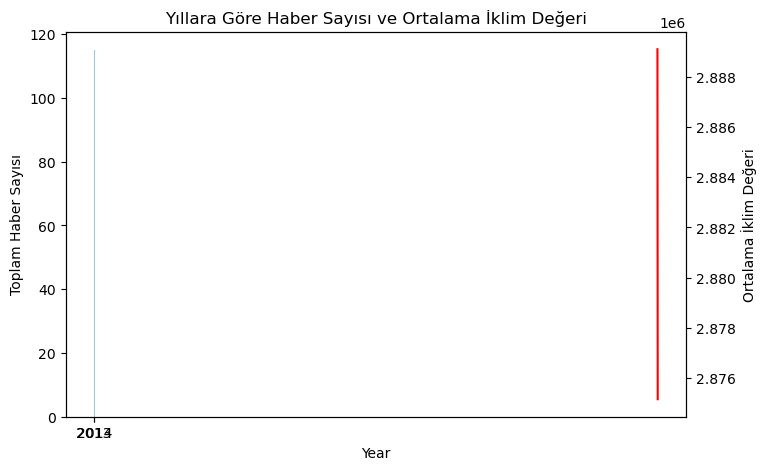

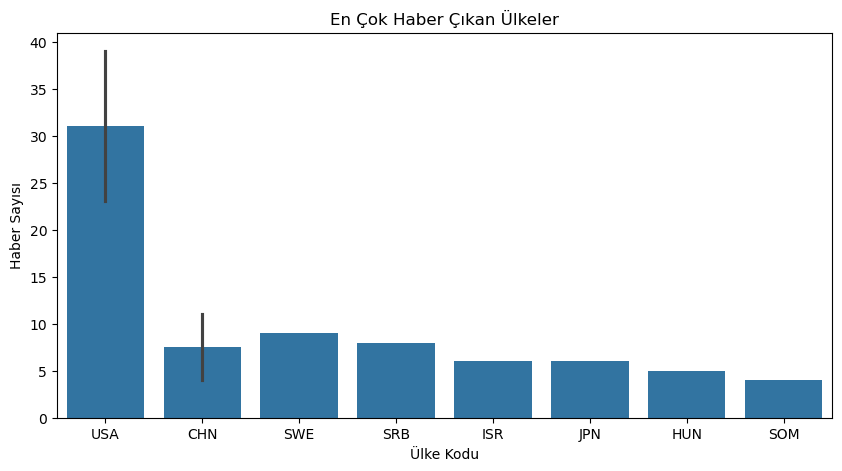

In [6]:
# Spark DataFrame'i Pandas'a çevir
summary_pd = summary_df.toPandas()
yearly_pd = yearly_df.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Yıllara göre toplam haber sayısı ve ortalama iklim değeri
fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()
sns.barplot(x="Year", y="total_news", data=yearly_pd, ax=ax1, color="skyblue")
sns.lineplot(x="Year", y="avg_climate_value", data=yearly_pd, ax=ax2, color="red")
ax1.set_ylabel("Toplam Haber Sayısı")
ax2.set_ylabel("Ortalama İklim Değeri")
plt.title("Yıllara Göre Haber Sayısı ve Ortalama İklim Değeri")
plt.show()

# 2. Ülkelere göre haber sayısı (en çok çıkan ilk 10 ülke)
top_countries = summary_pd.sort_values("news_count", ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x="country_code", y="news_count", data=top_countries)
plt.title("En Çok Haber Çıkan Ülkeler")
plt.ylabel("Haber Sayısı")
plt.xlabel("Ülke Kodu")
plt.show()

Pearson Korelasyon Matrisi:
                news_count  climate_value
news_count       1.000000       0.492589
climate_value    0.492589       1.000000


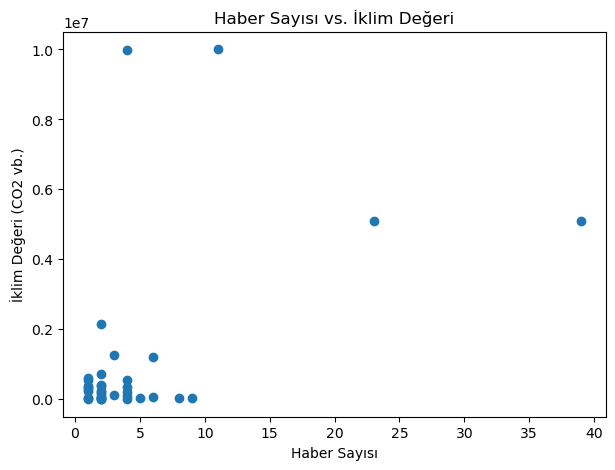

In [7]:
# Pandas DataFrame üzerinden korelasyon
corr = summary_pd[["news_count", "climate_value"]].corr(method="pearson")
print("Pearson Korelasyon Matrisi:\n", corr)

# Scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(summary_pd["news_count"], summary_pd["climate_value"])
plt.xlabel("Haber Sayısı")
plt.ylabel("İklim Değeri (CO2 vb.)")
plt.title("Haber Sayısı vs. İklim Değeri")
plt.show()

Pearson Korelasyon Matrisi:
                news_count  climate_value
news_count       1.000000       0.492589
climate_value    0.492589       1.000000


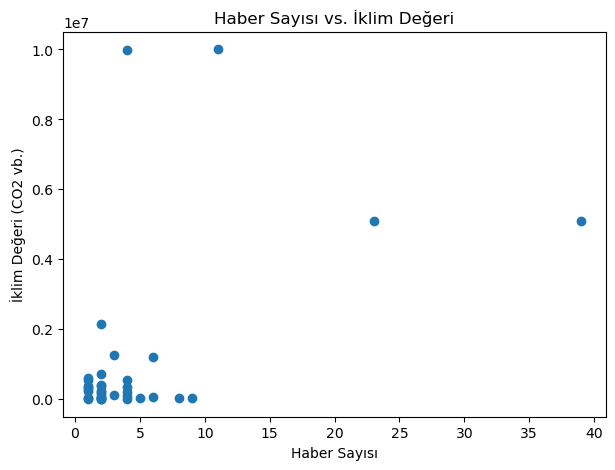

In [8]:
# Korelasyon matrisi
corr = summary_pd[["news_count", "climate_value"]].corr(method="pearson")
print("Pearson Korelasyon Matrisi:\n", corr)

# Scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(summary_pd["news_count"], summary_pd["climate_value"])
plt.xlabel("Haber Sayısı")
plt.ylabel("İklim Değeri (CO2 vb.)")
plt.title("Haber Sayısı vs. İklim Değeri")
plt.show()

In [9]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

# Yıllık toplam haber sayısı ve iklim değeri
yearly_pd = yearly_pd.sort_values("Year")
if len(yearly_pd) > 2:  # En az 3 yıl olmalı
    # Haber sayısı için AR modeli
    model_news = AutoReg(yearly_pd["total_news"], lags=1, old_names=False).fit()
    pred_news = model_news.predict(start=0, end=len(yearly_pd)-1)
    plt.plot(yearly_pd["Year"], yearly_pd["total_news"], label="Gerçek")
    plt.plot(yearly_pd["Year"], pred_news, label="Tahmin")
    plt.title("Yıllara Göre Haber Sayısı (AR Model)")
    plt.legend()
    plt.show()
else:
    print("Zaman serisi modelleme için daha fazla yıl verisi gerekli.")

Zaman serisi modelleme için daha fazla yıl verisi gerekli.


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Basit regresyon (ülke bazında)
X = summary_pd[["news_count", "avg_tone"]]
y = summary_pd["climate_value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
print("Random Forest R2 Skoru:", score)

Random Forest R2 Skoru: -4.906334325521915


In [13]:
from data_processing.scraping import batch_scrape
from data_processing.nlp_pipeline import batch_sentiment

In [15]:
from data_processing.scraping import batch_scrape
from data_processing.nlp_pipeline import batch_sentiment

import pandas as pd

# Test için örnek URL listesi
urls = [
    "https://www.example.com/",
    "https://www.iana.org/domains/example"
]

articles = batch_scrape(urls, sleep_time=1.0)
articles_df = pd.DataFrame(articles)
articles_df["sentiment"] = batch_sentiment(articles_df["text"].tolist())
print(articles_df[["url", "sentiment"]].head())

                                    url  sentiment
0              https://www.example.com/   0.250000
1  https://www.iana.org/domains/example   0.119444


In [16]:
from data_processing.scraping import batch_scrape
from data_processing.nlp_pipeline import batch_sentiment

import pandas as pd

# Spark DataFrame'den örnek URL listesi çek (örnek: merged_df)
# Eğer Spark DataFrame'in yoksa, örnek bir listeyle de test edebilirsin
try:
    # Spark DataFrame'den ilk 10 URL'yi çek
    urls = merged_df.select("SOURCEURL").dropna().distinct().limit(10).toPandas()["SOURCEURL"].tolist()
except Exception:
    # Test için örnek URL listesi
    urls = [
        "https://www.example.com/",
        "https://www.iana.org/domains/example"
    ]

# 1. Haber metinlerini çek
articles = batch_scrape(urls, sleep_time=1.0)  # sleep_time'ı düşük tutabilirsin

# 2. Pandas DataFrame'e çevir
articles_df = pd.DataFrame(articles)

# 3. Duygu analizi uygula
articles_df["sentiment"] = batch_sentiment(articles_df["text"].tolist())

# 4. Sonuçları göster
print(articles_df[["url", "sentiment"]].head())

# 5. (Opsiyonel) Tüm metni ve duygu skorunu incele
for idx, row in articles_df.iterrows():
    print(f"URL: {row['url']}\nSentiment: {row['sentiment']}\nText (ilk 300 karakter):\n{str(row['text'])[:300]}\n{'-'*60}")

                                                 url  sentiment
0  https://www.spokesman.com/stories/2024/may/06/...   0.101649
1  https://urbanmilwaukee.com/pressrelease/state-...   0.152085
2  https://www.middleeasteye.net/news/rafah-invas...  -0.012245
3  https://xpatloop.com/channels/2024/05/hungaria...   0.036026
4  https://www.pharmacytimes.com/view/lung-cancer...   0.009253
URL: https://www.spokesman.com/stories/2024/may/06/university-of-washington-rejects-protesters-calls-/
Sentiment: 0.10164884135472368
Text (ilk 300 karakter):
Color Scheme Subscriber Actions Staff Options Connect With Us Support Local Journalism SEATTLE —University of Washington President Ana Mari Cauce minced no words in February when student protesters demanded that the university cut ties with Boeing. “Boeing’s support for the UW in time, talent and fu
------------------------------------------------------------
URL: https://urbanmilwaukee.com/pressrelease/state-sanctioned-inequity/
Sentiment: 0.1520851370

In [17]:
articles_df.to_csv("scraped_articles_with_sentiment.csv", index=False)